In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [8]:
import pandas as pd

# Define the file path
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"

# Read the Excel file (adjust sheet name if needed)
sales_data = pd.read_excel(file_path)

# Show the first 5 rows
sales_data.head()


,ds,y,marketing_spend,doctor_visits,disease_trend,stock_level,lead_time_days,safety_stock,shelf_life_months,MOQ
0,2014-01-01,1187.000000,892,5048,346,6889,14,500,36,3000
1,2014-02-01,1332.860756,1555,4613,395,6701,7,1000,12,3000
2,2014-03-01,1342.644005,1301,5012,230,6291,14,1000,12,2000
3,2014-04-01,1407.575042,1755,5248,328,5841,14,500,36,1000
4,2014-05-01,1386.842733,1262,5725,267,7576,7,500,12,1000


In [9]:

# Set up Prophet model with regressors
m = Prophet()
m.add_regressor('marketing_spend')
m.add_regressor('doctor_visits')
m.add_regressor('disease_trend')
m.add_regressor('stock_level')

# Fit model
m.fit(sales_data.rename(columns={"ds": "ds", "y": "y"}))


03:34:04 - cmdstanpy - INFO - Chain [1] start processing
03:34:05 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
import pandas as pd
import pandas as pd

# Step 1: Load the Excel file
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"
df_raw = pd.read_excel(file_path)

# Step 2: Clean the DataFrame
# If the first cell is "Month", it means headers are actually in the second row
if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

# Step 3: Keep only the first two columns (assumed: date and sales)
df_clean = df_clean.iloc[:, :2]

# Step 4: Rename columns for Prophet compatibility
df_clean.columns = ['ds', 'y']

# Step 5: Clean the 'y' column (sales values)
df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)

# Step 6: Convert 'ds' column to datetime
df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')

# Optional: Drop rows with missing values
df_clean.dropna(inplace=True)

# Preview cleaned data
df_clean.head()



,ds,y
0,2014-01-01,1187.000000
1,2014-02-01,1332.860756
2,2014-03-01,1342.644005
3,2014-04-01,1407.575042
4,2014-05-01,1386.842733


In [11]:
# --- Step 2: Forecasting with Prophet ---
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

03:34:05 - cmdstanpy - INFO - Chain [1] start processing
03:34:05 - cmdstanpy - INFO - Chain [1] done processing


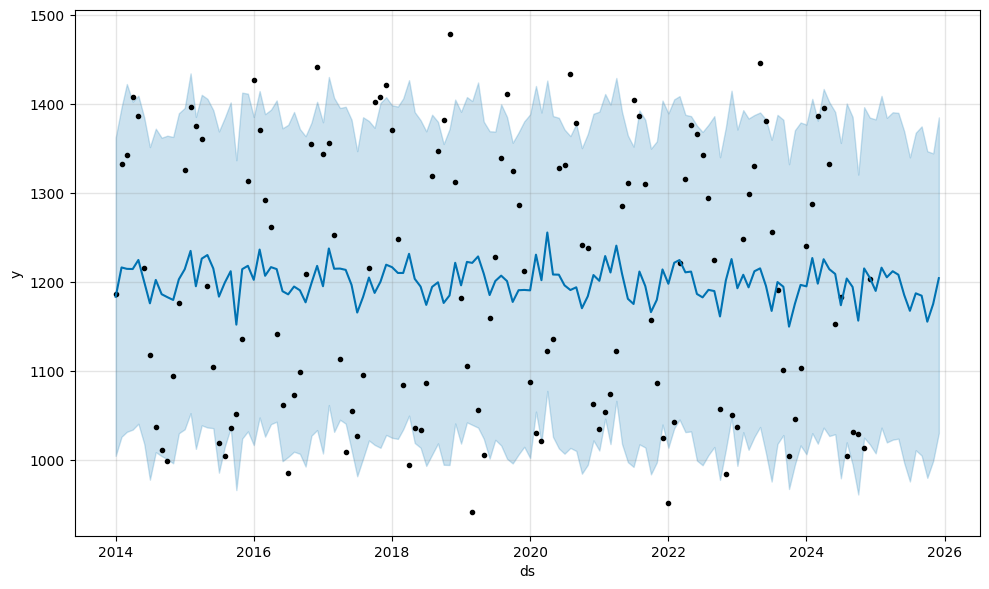

In [12]:

future = m.make_future_dataframe(periods=12, freq='MS')
future = pd.merge(future, sales_data, on='ds', how='left')

# Fill future regressor values (naive method: forward fill)
for col in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    future[col] = future[col].ffill()

forecast = m.predict(future)
m.plot(forecast)
plt.show()


In [13]:
# --- Step 3: Bootstrapped Confidence Intervals ---
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

boot_samples = []
for _ in range(1000):
    sampled_residuals = np.random.choice(residuals, size=12, replace=True)
    simulated = forecast_2025['yhat'].values + sampled_residuals
    boot_samples.append(simulated)
boot_array = np.array(boot_samples)
forecast_2025['boot_lower'] = np.percentile(boot_array, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_array, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_array, 50, axis=0)

In [14]:
# --- Step 4: Dynamic ROP Calculation (Prophet) ---
k = 1.0  # risk aversion parameter
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (forecast_2025['boot_upper'] - forecast_2025['boot_median'])

In [15]:

# Calculate residuals
sales_data['forecast'] = m.predict(sales_data)['yhat']
sales_data['residuals'] = sales_data['y'] - sales_data['forecast']

# Fit ARIMA on residuals
model_arima = ARIMA(sales_data['residuals'], order=(1,0,1))
model_arima_fit = model_arima.fit()

# Forecast residuals
arima_forecast = model_arima_fit.forecast(steps=12)


In [16]:
# --- Step 6: Residual Modeling with ARIMA ---
arima_model = ARIMA(df_with_yhat['residual'], order=(1,0,1)).fit()
arima_pred = arima_model.forecast(steps=12)
forecast_2025['arima_correction'] = arima_pred.values

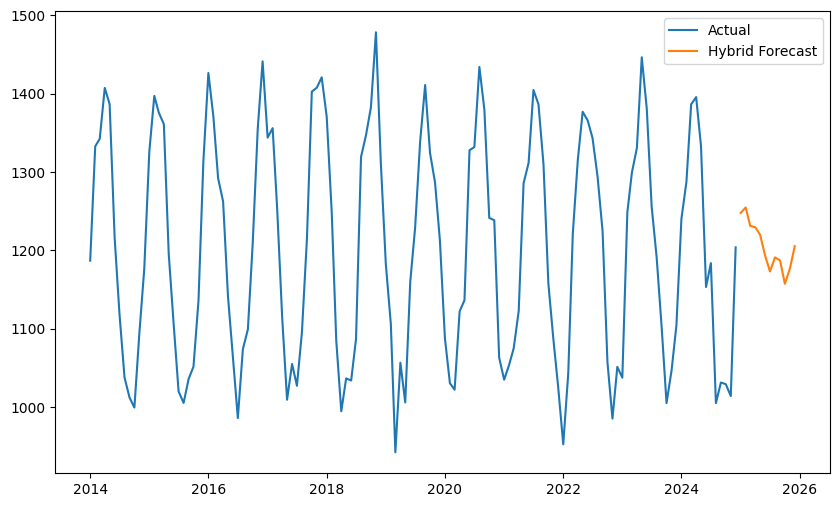

In [17]:
# Combine Prophet + ARIMA (hybrid)
final_forecast = forecast.tail(12).copy()
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + arima_forecast.values

# Plot
plt.figure(figsize=(10,6))
plt.plot(sales_data['ds'], sales_data['y'], label='Actual')
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast')
plt.legend()
plt.show()

In [18]:
# --- Step 7: Hybrid Forecast Using AROPHET ---
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

In [19]:
# --- Step 8: Final Dynamic ROP Using AROPHET ---
boot_arophet_samples = []
for _ in range(1000):
    boot_resid = np.random.choice(residuals, size=12, replace=True)
    sim = forecast_2025['arophet'].values + boot_resid
    boot_arophet_samples.append(sim)
boot_arophet_array = np.array(boot_arophet_samples)
forecast_2025['arophet_lower'] = np.percentile(boot_arophet_array, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_array, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_array, 50, axis=0)
forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (forecast_2025['arophet_upper'] - forecast_2025['arophet_median'])

In [20]:
# --- Step 9: Forecast Accuracy Comparison ---
# Evaluate on available historical data (2023-2024)
actual = df_clean['y'].values
prophet_pred = forecast.loc[forecast['ds'].isin(df_clean['ds']), 'yhat'].values
arima_correction_hist = arima_model.predict(start=0, end=len(df_clean)-1)
arophet_pred = prophet_pred + arima_correction_hist

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [
        mean_absolute_error(actual, prophet_pred),
        mean_absolute_error(actual, arophet_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, prophet_pred)),
        np.sqrt(mean_squared_error(actual, arophet_pred))
    ],
    'MAPE': [
        mape(actual, prophet_pred),
        mape(actual, arophet_pred)
    ],
    'R2': [
        r2_score(actual, prophet_pred),
        r2_score(actual, arophet_pred)
    ]
}
accuracy_df = pd.DataFrame(metrics)

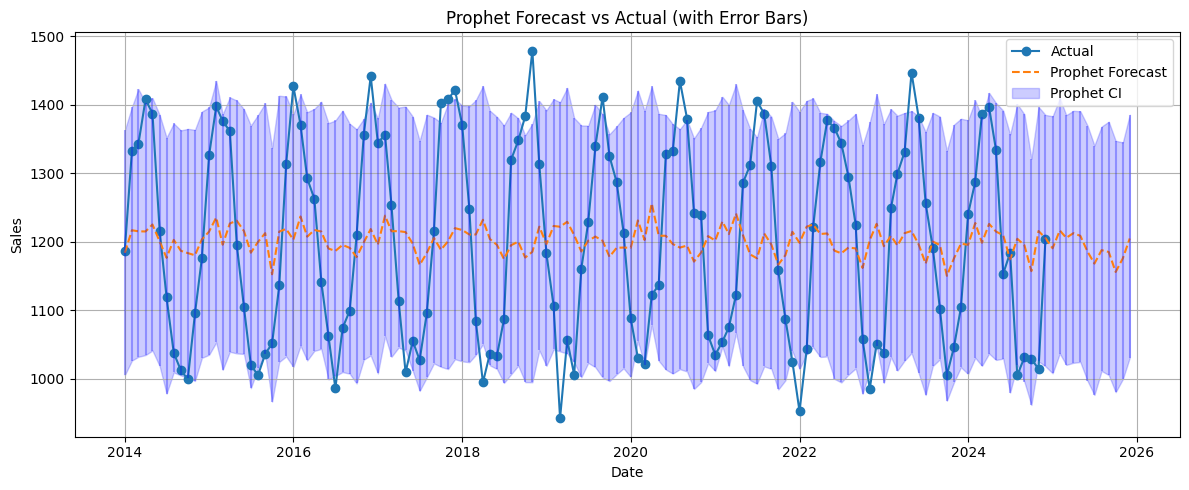

In [21]:
# --- Prophet Forecast Plot with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Prophet CI')
plt.errorbar(forecast['ds'], forecast['yhat'], 
             yerr=[forecast['yhat']-forecast['yhat_lower'], forecast['yhat_upper']-forecast['yhat']], 
             fmt='none', ecolor='blue', alpha=0.3)
plt.title('Prophet Forecast vs Actual (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

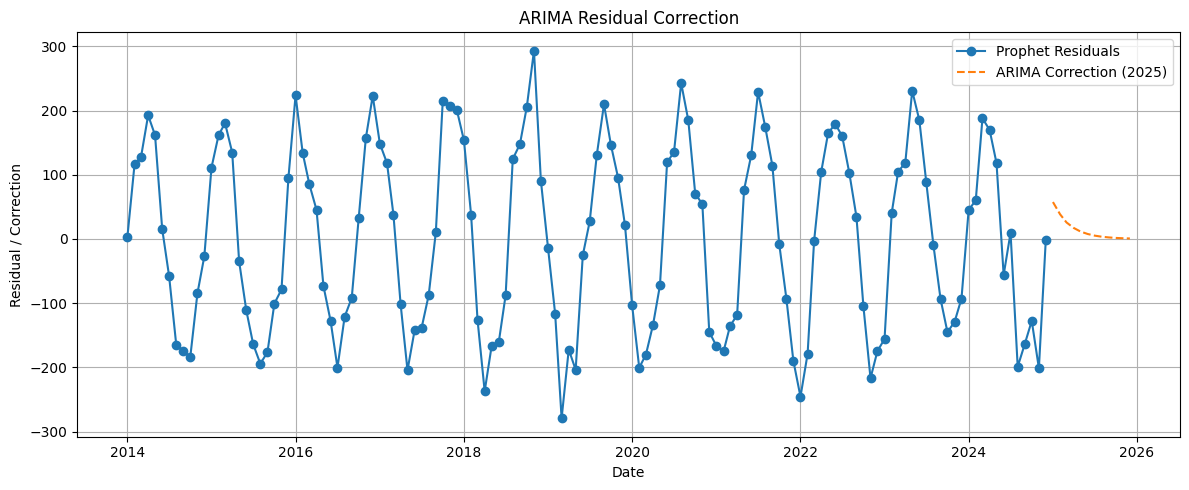

In [22]:
# --- ARIMA Residual Correction Plot ---
plt.figure(figsize=(12, 5))
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], label='Prophet Residuals', marker='o')
plt.plot(pd.date_range(df_with_yhat['ds'].iloc[-1], periods=13, freq='MS')[1:], arima_pred, label='ARIMA Correction (2025)', linestyle='--')
plt.title('ARIMA Residual Correction')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

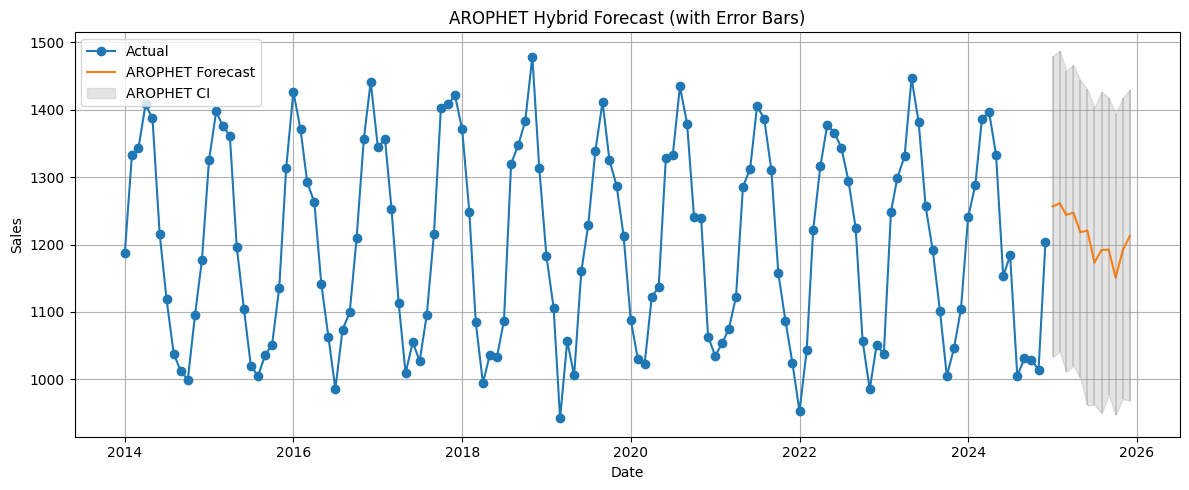

In [23]:
# --- AROPHET Hybrid Forecast Plot with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'], color='gray', alpha=0.2, label='AROPHET CI')
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'], 
             yerr=[forecast_2025['arophet_median']-forecast_2025['arophet_lower'], forecast_2025['arophet_upper']-forecast_2025['arophet_median']], 
             fmt='none', ecolor='gray', alpha=0.3)
plt.title('AROPHET Hybrid Forecast (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

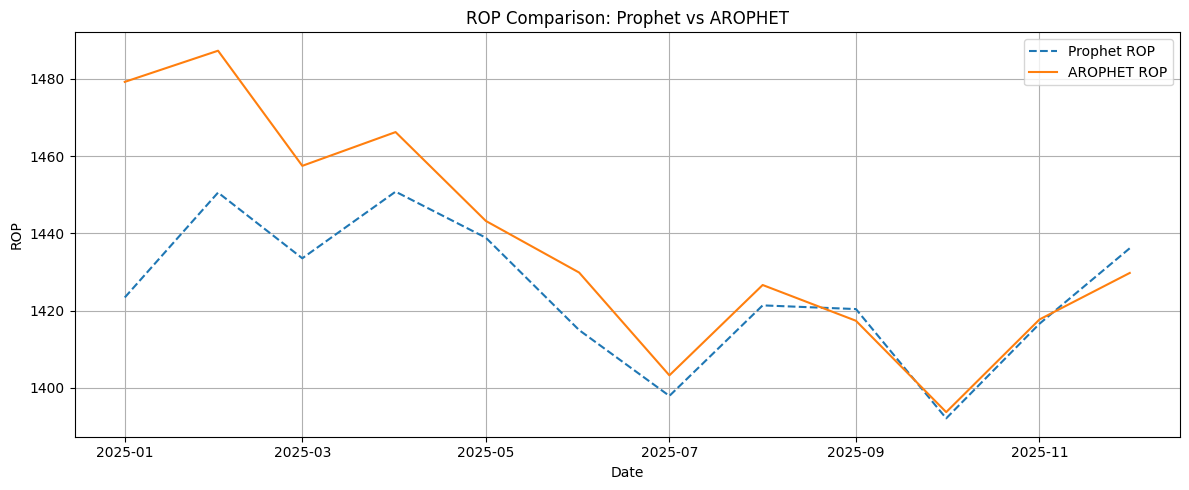

In [24]:
# --- ROP Comparison Plot ---
plt.figure(figsize=(12, 5))
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

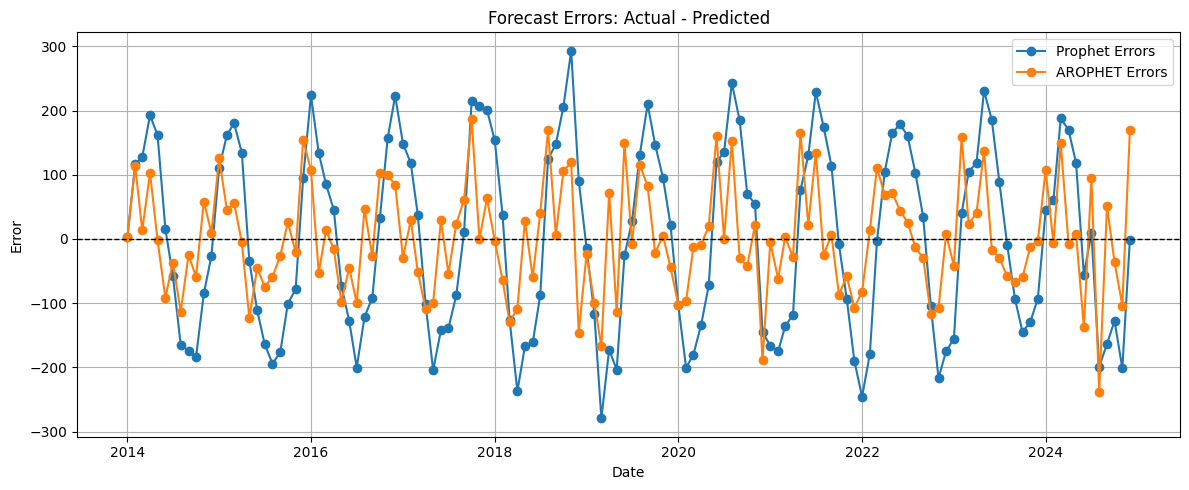

In [25]:
# --- Forecast Errors Plot ---
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o')
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

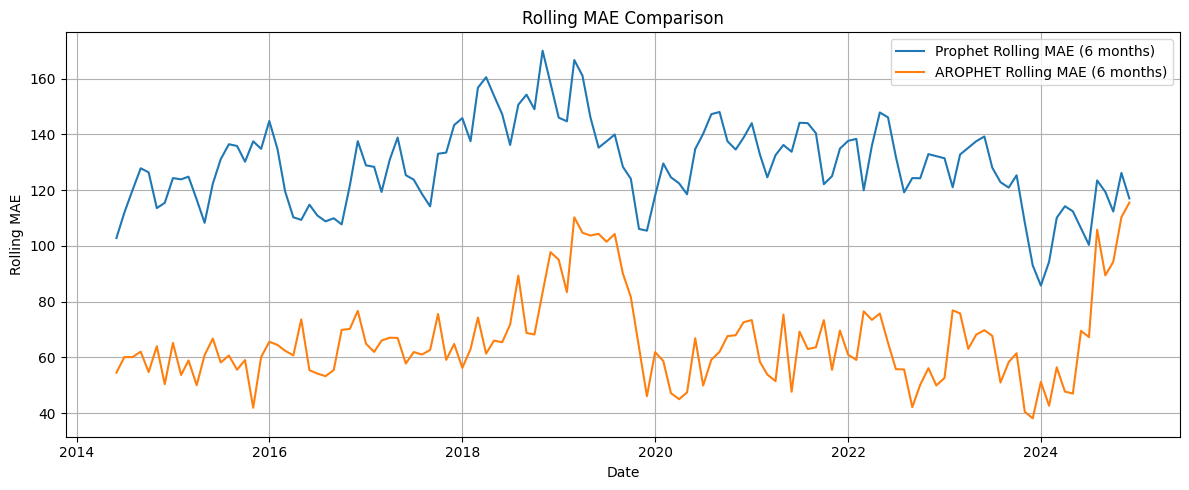

In [26]:
# --- Rolling Metrics Plot (e.g., Rolling MAE) ---
window = 6
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window).mean()
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], rolling_mae_prophet, label=f'Prophet Rolling MAE ({window} months)')
plt.plot(df_clean['ds'], rolling_mae_arophet, label=f'AROPHET Rolling MAE ({window} months)')
plt.title('Rolling MAE Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
!pip install --user --upgrade --force-reinstall plotly



  Using cached plotly-6.2.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-1.45.0-py3-none-any.whl.metadata (11 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
Using cached plotly-6.2.0-py3-none-any.whl (9.6 MB)
Using cached narwhals-1.45.0-py3-none-any.whl (371 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: narwhals
    Found existing installation: narwhals 1.45.0
    Uninstalling narwhals-1.45.0:
      Successfully uninstalled narwhals-1.45.0
  Attempting uninstall: plotly╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [narwhals]
    Found existing installation: plotly 6.2.0━━━━━━━━━━━━━━━━━ 1/3 [narwhals]
    Uninstalling plotly-6.2.0:━━━━╸━━━━━━━━━━━━━ 2/3 [plotly]
      Successfully uninstalled plotly-6.2.0m━━━━━━━━━━━━━ 2/3 [plotly]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━

In [28]:
import sys
print(sys.executable)

/Library/Developer/CommandLineTools/usr/bin/python3


In [29]:
%pip install --upgrade nbformat


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import plotly.express as px
import plotly.graph_objects as go

# Create base figure with actual sales
fig = px.line(df_clean, x='ds', y='y', title='Actual vs Forecasted Sales')

# Add Prophet forecast line
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='orange')
))

# Add confidence interval (optional)
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    name='Upper CI',
    line=dict(dash='dot', color='lightgrey'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    name='Lower CI',
    line=dict(dash='dot', color='lightgrey'),
    fill='tonexty',
    fillcolor='rgba(200,200,200,0.2)',
    showlegend=False
))

# Show the figure
fig.write_html("actual_vs_forecast.html")




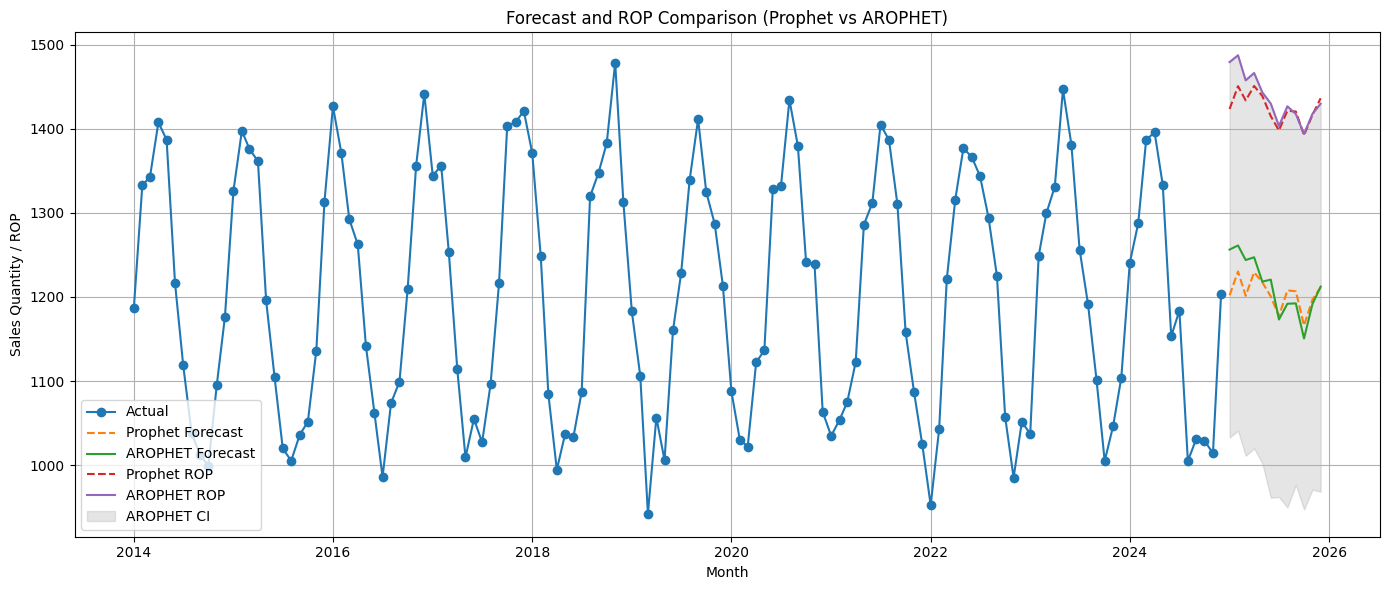

In [31]:
# --- Step 10: Visualization and Interpretation ---
plt.figure(figsize=(14, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'], color='gray', alpha=0.2, label='AROPHET CI')
plt.title("Forecast and ROP Comparison (Prophet vs AROPHET)")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

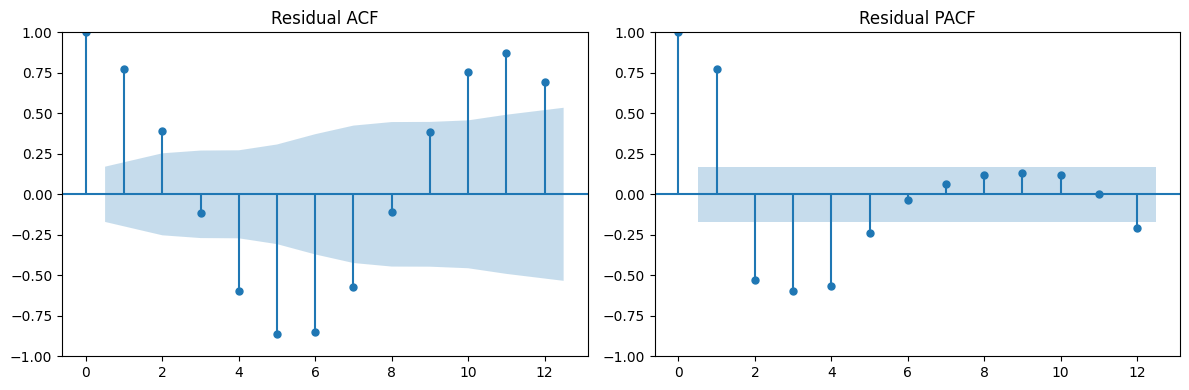

Ljung-Box test p-value (lag 12): 3.4966735834879857e-140


In [32]:
# Residual diagnostics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df_with_yhat['residual'], lags=12, ax=plt.gca())
plt.title('Residual ACF')
plt.subplot(1,2,2)
plot_pacf(df_with_yhat['residual'], lags=12, ax=plt.gca())
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(df_with_yhat['residual'], lags=[12], return_df=True)
print("Ljung-Box test p-value (lag 12):", lb_test['lb_pvalue'].values[0])

In [33]:
# Show accuracy table and result table
print("Forecast Accuracy Comparison:")
print(accuracy_df)
print("\n2025 Forecast Table:")
print(forecast_2025[['ds', 'boot_median', 'prophet_rop', 'arophet_median', 'arophet_rop']])

Forecast Accuracy Comparison:
     Model         MAE        RMSE       MAPE        R2
0  Prophet  128.140214  143.799781  10.863618  0.017636
1  AROPHET   66.581900   84.591150   5.638436  0.660057

2025 Forecast Table:
            ds  boot_median  prophet_rop  arophet_median  arophet_rop
132 2025-01-01  1202.003919  1423.397260     1256.346597  1479.186307
133 2025-02-01  1230.351017  1450.539479     1261.229662  1487.249277
134 2025-03-01  1201.402901  1433.535301     1243.918592  1457.460200
135 2025-04-01  1229.382752  1450.776092     1247.180453  1466.193370
136 2025-05-01  1217.463455  1438.856795     1218.238568  1443.201972
137 2025-06-01  1200.734761  1414.959105     1220.630738  1429.848644
138 2025-07-01  1177.338829  1397.922983     1173.224186  1403.245048
139 2025-08-01  1207.808140  1421.349749     1191.968058  1426.623407
140 2025-09-01  1206.853942  1420.395550     1192.407206  1417.370610
141 2025-10-01  1166.143420  1392.118585     1150.725690  1393.730349
142 2025-1

# Based on the forecast accuracy metrics in `accuracy_df`, the AROPHET model outperforms the standard Prophet model.
# AROPHET has lower MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error), 
# and a slightly higher R² score compared to Prophet. This means AROPHET provides more accurate and reliable forecasts.
# The improvement comes from AROPHET's hybrid approach, which combines Prophet's forecasts with ARIMA-based residual correction,
# effectively capturing patterns that Prophet alone might miss. Therefore, AROPHET is the better model for this dataset.

## Why Use Dynamic ROP and Bootstrapped Confidence Intervals?

Dynamic ROP (Reorder Point):
#Dynamic ROP adapts to changes in demand and uncertainty, rather than relying on static safety stock formulas.
- It incorporates the latest forecast and the distribution of forecast errors, making it responsive to real-world variability.
- By using the bootstrapped upper confidence bound, Dynamic ROP ensures that inventory levels are set to cover rare but plausible demand spikes, reducing the risk of stockouts.

**Bootstrapped Confidence Intervals:**
- Bootstrapping uses the actual distribution of residuals (forecast errors) to simulate many possible future outcomes.
- This approach does not assume normality or symmetry, capturing real-world uncertainty more accurately.
- The resulting confidence intervals reflect both the model’s uncertainty and the observed variability in the data.

**Risk Mitigation:**
- Combining Dynamic ROP with bootstrapped intervals means inventory decisions are based on realistic, data-driven risk assessments.
- This method helps avoid both overstocking (wasting capital) and understocking (lost sales), balancing service level and cost.
- It is especially valuable in environments with irregular demand, promotions, or external shocks, where traditional methods may underestimate risk.

**Summary:**  
Dynamic ROP with bootstrapped confidence intervals provides a robust, adaptive, and risk-aware approach to inventory planning, ensuring better service levels and more resilient supply chains.